In [1]:
import pyfastchem as pyfc
import os
import petitRADTRANS.physical_constants as nc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from tqdm import tqdm

In [ ]:
class FastChemistry():

    def __init__(self, pressures, rainout=True):

        self.pressures = pressures

        # pyfc_path = os.path.dirname(pyfc.__file__)
        pyfc_path = os.path.abspath('/net/lem/data1/regt/fastchem/')
        # self.element_file   = f'{pyfc_path}/input/element_abundances/asplund_2020_extended.dat'
        self.element_file   = f'{pyfc_path}/input/element_abundances/bergemann_2025_protosolar.dat'
        # self.logK_gas_file  = f'{pyfc_path}/input/logK/logK_extended.dat'
        # self.logK_cond_file = f'{pyfc_path}/input/logK/logK_condensates.dat'
        # self.logK_gas_file  = f'{pyfc_path}/input/logK/logK_extended_lithium.dat'
        # self.logK_cond_file = f'{pyfc_path}/input/logK/logK_condensates_lithium.dat'
        self.logK_gas_file  = f'{pyfc_path}/input/logK/2024-11-21_logK_li_ge.dat'
        self.logK_cond_file = f'{pyfc_path}/input/logK/logK_new_cond_li_ge.dat'

        self.fastchem = pyfc.FastChem(
            self.element_file, self.logK_gas_file, self.logK_cond_file, 1
            )

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        # Use rainout condensation approach
        self.input.equilibrium_condensation = True
        self.input.rainout_condensation     = rainout

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-6)
        self.fastchem.setParameter('accuracyElementConservation', 1e-6)
        
        self.fastchem.setParameter('nbIterationsChem', 100000)
        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        self.index_Li = np.array(self.fastchem.getElementIndex('Li'))

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        gas_number_density = np.array(self.output.number_densities)[::-1,index]
        return (gas_number_density / self.gas_number_density_tot)
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]
    
    def get_element_cond_degree(self, element_i):
        index = self.fastchem.getElementIndex(element_i)
        return np.array(self.output.element_cond_degree)[::-1,index]
    
    def get_element_number_density(self, element_i):
        index = self.fastchem.getElementIndex(element_i)
        total_element_density  = np.array(self.output.total_element_density)[::-1]
        total_element_density *= np.array(self.fastchem.getElementAbundance(index)) / np.sum(self.fastchem.getElementAbundances())
        return (total_element_density / self.gas_number_density_tot)

    def __call__(self, T, CO=None, LiF=None, FeH=0., el_abund={'Li':10**(3.28-12)}, min_T=100.):

        temperature = T * np.ones_like(self.pressures)
        if (temperature < min_T).any():
            print(f'Replaced T<{min_T} with T={min_T} K')
            temperature[temperature<min_T] = min_T

        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        for element_i in el_abund.keys():
            index = self.fastchem.getElementIndex(element_i)
            element_abundances[index] = el_abund[element_i]

        # Apply C/O ratio and Fe/H to elemental abundances
        if CO is not None:
            CO_correction = (1 + element_abundances[self.index_C]/element_abundances[self.index_O]) / (1+CO)
            element_abundances[self.index_C] = element_abundances[self.index_O] * CO
            element_abundances[self.index_C] *= CO_correction
            element_abundances[self.index_O] *= CO_correction

        if LiF is not None:
            index_F = self.fastchem.getElementIndex('F')
            LiF_correction = (1 + element_abundances[self.index_Li]/element_abundances[index_F]) / (1+LiF)
            element_abundances[self.index_Li] = element_abundances[index_F] * LiF
            element_abundances[self.index_Li] *= LiF_correction
            element_abundances[index_F]       *= LiF_correction

        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        self.gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (nc.kB * np.array(self.input.temperature))
        self.gas_number_density_tot = self.gas_number_density_tot[::-1]  # Flip for FastChem usage

In [3]:
# T_eff = np.arange(700, 2400+1e-6, 300)
T_eff = np.array([400, 700, 1000, 1300, 1600, 1900, 2200])
# T_eff = np.array([700,1000])
# T_eff = np.array([400])

# T_eff = np.array([400, 700, 1000, 1300])

# VMR_tot = {'F': [], 'Fe': []}
# VMR  = {'F1H1': [], 'Fe': [], 'Fe1H1': [], 'Mg': [], 'Al1F1': [], 'Na': [], 'K': []}
VMR_tot = {'Li': [], 'C': [], 'O': [], 'S': [], 'N': [], 'F': [], 'P': []}
VMR  = {'F1H1': [], 'C1O1': [], 'C1H4': [], 'H2O1': [], 'C1O2': [], 'H1O1': [], 'H2S1': [], 'H3N1': [], 'Al1F1': [], 'H1S1': [], 'C1O2': [], 'N2': [], 'Li': [], 'F1Li1': [], 'Cl1Li1': [], 'H1Li1O1': [], 'H1Li1': [], 'F1H1O1': [], 'H3P1': [], 'S': []}
cond = {'LiF(s,l)': [], 'Mg2SiO4(s,l)': [], 'MgSiO3(s,l)': [], 'SiO(s)': [], 'Fe(s,l)': [], 'Na2S(s,l)': []}
cond_degree = {'Li': [], 'C': [], 'O': [], 'S': [], 'N': [], 'F': [], 'P': []}
P = []
T = []

for FeH_i in [0.0]:
    for T_eff_i in tqdm(T_eff):

        # Read temperature profile
        #path = '/home/sam/Documents/PhD/fastchem_tests/SONORA_ElfOwl_PT/' + \
        path = '/net/lem/data2/regt/SONORA_Elf_Owl/PT_profiles/' + \
            'spectra_logzz_7.0_teff_{:.1f}_grav_1000.0_mh_{:.1f}_co_1.0.dat'.format(T_eff_i, FeH_i)
            #'spectra_logzz_9.0_teff_{:.1f}_grav_1000.0_mh_0.0_co_1.0.dat'.format(T_eff_i)
        pressure, temperature = np.loadtxt(path).T

        # Compute the chemical equilibrium abundances
        FC = FastChemistry(pressures=pressure, rainout=True)
        
        # CO = FC.solar_abundances[FC.index_C]/FC.solar_abundances[FC.index_O]
        # LiF = FC.solar_abundances[FC.index_Li]/FC.solar_abundances[FC.fastchem.getElementIndex('F')]
        # LiF = 0.6
        CO=None; LiF=None
        FC(T=temperature, CO=CO, LiF=LiF, FeH=FeH_i)

        P.append(pressure)
        # T.append(FC.input.temperature[::-1])
        T.append(temperature)

        for hill_i in VMR.keys():
            VMR[hill_i].append(FC.get_VMR(hill_i))
        for hill_i in cond.keys():
            cond[hill_i].append(FC.get_condensate_number_density(hill_i))
        
        for element_i in cond_degree.keys():
            cond_degree[element_i].append(FC.get_element_cond_degree(element_i))

        for element_i in VMR_tot.keys():
            VMR_tot_i = FC.get_element_number_density(element_i)
            VMR_tot[element_i].append(VMR_tot_i)

  0%|                                                                                                                                                                                    | 0/7 [00:00<?, ?it/s]

Replaced T<100.0 with T=100.0 K


 14%|████████████████████████▌                                                                                                                                                   | 1/7 [00:07<00:42,  7.15s/it]

Failed element conservation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.76s/it]


In [4]:
PT_cond = {species_i: [] for species_i in cond.keys()}
for species_i, n_i in cond.items():
    
    for j in range(len(P)):
        n_ij = n_i[j]
        mask_condensed = (n_ij != 0.)
        if not mask_condensed.any():
            continue
        
        idx = np.argwhere(mask_condensed).max()
        if idx == len(n_ij)-1:
            continue
        PT_cond[species_i].append([P[j][idx], T[j][idx]])

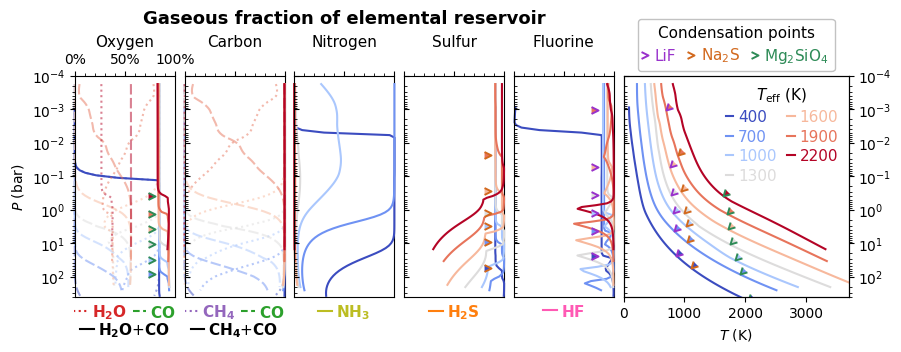

In [5]:
ylim = (4e2,1e-4)

color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1'}
cmap = plt.get_cmap('coolwarm')
N = len(T_eff)

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=6, wspace=0.08, width_ratios=[0.2,0.2,0.2,0.2,0.2,0.45])
# gs = fig.add_gridspec(nrows=1, ncols=7, wspace=0.08, width_ratios=[0.25,0.25,0.15,0.15,0.25,0.07,0.4])
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[0,2]), 
    fig.add_subplot(gs[0,3]), 
    fig.add_subplot(gs[0,4]), 
    fig.add_subplot(gs[0,-1]), 
])

for i, T_eff_i in enumerate(T_eff):

    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]-10
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    kwargs = dict(c=c, lw=1.5, zorder=zorder, clip_on=False)
    ax[-1].plot(T[i], P[i], c=c, lw=1.5, label='{:.0f}'.format(T_eff_i))

    # for j, lw in zip([i,i+N,i+2*N], [1,1.5,2]):
    for j, lw in zip([i], [1.5]):
        P_ij = P[j]
        P_ij[P_ij >= ylim[0]] = np.nan

        # O, C, N, S, F
        VMR_tot_i = VMR_tot['O'][j]
        ax[0].plot((VMR['C1O1'][j]+VMR['H2O1'][j])/VMR_tot_i, P_ij, **kwargs)
        ax[0].plot(VMR['C1O1'][j]/VMR_tot_i, P_ij, ls=(0,(5,1.65)), alpha=0.5, **kwargs)
        ax[0].plot(VMR['H2O1'][j]/VMR_tot_i, P_ij, ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        VMR_tot_i = VMR_tot['C'][j]
        ax[1].plot((VMR['C1O1'][j]+VMR['C1H4'][j])/VMR_tot_i, P_ij, **kwargs)
        ax[1].plot(VMR['C1O1'][j]/VMR_tot_i, P_ij, ls=(0,(5,1.65)), alpha=0.5, **kwargs)
        ax[1].plot(VMR['C1H4'][j]/VMR_tot_i, P_ij, ls=(0,(1,1.65)), alpha=0.5, **kwargs)

        VMR_tot_i = VMR_tot['N'][j]
        ax[2].plot(VMR['H3N1'][j]/VMR_tot_i, P_ij, **kwargs)

        VMR_tot_i = VMR_tot['S'][j]
        ax[3].plot(VMR['H2S1'][j]/VMR_tot_i, P_ij, **kwargs)
        # ax[3].plot(VMR['H1S1'][j]/VMR_tot_i, P_ij, ls=(0,(1,1.65)), alpha=0.5, **kwargs)
        # ax[3].plot(VMR['S'][j]/VMR_tot_i, P_ij, ls=(0,(5,1.65)), alpha=0.5, **kwargs)

        VMR_tot_i = VMR_tot['F'][j]
        ax[4].plot(VMR['F1H1'][j]/VMR_tot_i, P_ij, **kwargs)

from matplotlib.patches import Polygon

ax[-1].legend(
    loc='upper right', bbox_to_anchor=(1,1), ncols=2, edgecolor='none', facecolor='none', 
    columnspacing=0.7, handlelength=0.5, handletextpad=0.3, labelspacing=0.3, 
    labelcolor='linecolor', prop={'size':11}, borderpad=0.2, #borderaxespad=0.1, 
    title=r'$T_\mathrm{eff}\ \mathrm{(K)}$', title_fontsize=11, 
)
ax[2].set_title('Gaseous fraction of elemental reservoir', fontsize=13, fontweight='bold', pad=8)
ax[0].set(ylabel=r'$P\ (\mathrm{bar})$')
ax[-1].set(xlabel=r'$T\ (\mathrm{K})$', yscale='log', ylim=ylim, xlim=(0,3700))#, yticklabels=[])
for i, ax_i in enumerate(ax[:-1]):

    # xticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    # xticklabels = ['']*len(xticks)
    # if i == 0:
    #     xticklabels = ['0%', '', '', '', '', '50%', '', '', '', '', '100%']

    xticks = [0,0.5,1]; xticklabels = ['',' ','']
    if i in [0]:#,2,4]:
        xticks = [0,0.5,1]
        xticklabels = ['0%','50%','100%']

    ax_i.set(yscale='log', ylim=ylim, xlim=(0.,1.), xticks=xticks, xticklabels=xticklabels)
    # ax_i.axvline(1, c='k', lw=0.8, alpha=0.2, zorder=-1)

    ax_i.set_xticks(np.arange(0, 1.01, 0.1), minor=True)
 
    if i != 0:
        ax_i.set(yticklabels=[])
        ax_i.tick_params('y', which='both', direction='in')

    ax_i.spines['right'].set_zorder(-100)

    '''
    # ax_i.set(xscale='log', xlim=(0.05,3))
    # w = 0.039
    # w = 0.022
    w = 0.018
    # p = Polygon([[0,0],[1,w],[1,0]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    p = Polygon([[0,0],[1,0],[1,-w]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    # p = Polygon([[0,0],[1,w/2],[1,-w/2]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    ax_i.add_patch(p)
    p = Polygon([[0,1],[1,1],[1,1-w]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    # p = Polygon([[0,1],[1,1+w/2],[1,1-w/2]], fc='k', closed=True, transform=ax_i.get_xaxis_transform(), clip_on=False, zorder=-1)
    ax_i.add_patch(p)
    '''

    ax_i.xaxis.set_label_position('top')
    ax_i.xaxis.tick_top()

kwargs = dict(fontsize=11, labelpad=4)
ax[0].set_xlabel('Oxygen', **kwargs)
ax[1].set_xlabel('Carbon', **kwargs)
ax[2].set_xlabel('Nitrogen', **kwargs)
ax[3].set_xlabel('Sulfur', **kwargs)
ax[4].set_xlabel('Fluorine', **kwargs)

# Add legends to each axis
legend_kwargs = dict(
    loc='upper center', edgecolor='none', facecolor='none', 
    labelcolor='linecolor', prop={'size':11}, handlelength=0.9, handletextpad=0.25, 
    borderpad=0.1, borderaxespad=0.3, labelspacing=0.3, #markerfirst=False,
    columnspacing=0.4
)
ax[0].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf H_2O}$+$\mathrm{\bf CO}$')
ax[0].legend(bbox_to_anchor=(0.5,-0.08), **legend_kwargs)

ax_0 = ax[0].twinx(); ax_0.axis('off')
ax_0.plot(np.nan, np.nan, c=color_species['H2O'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf H_2O}$')
ax_0.plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.8,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax_0.legend(bbox_to_anchor=(0.5,0), ncols=2, **legend_kwargs)

ax[1].plot(np.nan, np.nan, c='k', lw=lw, label=r'$\mathrm{\bf CH_4}$+$\mathrm{\bf CO}$')
ax[1].legend(bbox_to_anchor=(0.5,-0.08), **legend_kwargs)

ax_1 = ax[1].twinx(); ax_1.axis('off')
ax_1.plot(np.nan, np.nan, c=color_species['CH4'], lw=lw, ls=(0.4,(1,1.65)), label=r'$\mathrm{\bf CH_4}$')
ax_1.plot(np.nan, np.nan, c=color_species['12CO'], lw=lw, ls=(1.8,(5,1.65)), label=r'$\mathrm{\bf CO}$')
ax_1.legend(bbox_to_anchor=(0.5,0), ncols=2, **legend_kwargs)

ax[2].plot(np.nan, np.nan, c=color_species['NH3'], lw=lw, label=r'$\mathrm{\bf NH_3}$')
ax[3].plot(np.nan, np.nan, c=color_species['H2S'], lw=lw, label=r'$\mathrm{\bf H_2S}$')
ax[4].plot(np.nan, np.nan, c=color_species['HF'], lw=lw, label=r'$\mathrm{\bf HF}$')

ax[2].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)
ax[3].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)
ax[4].legend(bbox_to_anchor=(0.5,0), **legend_kwargs)

w = 0.3
kwargs = dict(ls='', mew=1.4, mec='darkorchid', ms=10)
for i, PT_i in enumerate(PT_cond['LiF(s,l)']):
    c = cmap((T_eff[i]-T_eff.min())/(T_eff.max()-T_eff.min()))

    marker = ((w,1),(0,0),(1,w))
    ax[-1].plot(PT_i[1], PT_i[0], marker=marker, c=c, **kwargs)

    marker = ((-1,-1/2*np.sqrt(2)*(1-w)),(0,0),(-1,1/2*np.sqrt(2)*(1-w)))
    ax[4].plot(0.84, PT_i[0], marker=marker, transform=ax[4].get_yaxis_transform(), c=c, **kwargs)
    handle1, = ax[4].plot(
        np.nan, np.nan, marker=marker, label=f'LiF', transform=ax[4].get_yaxis_transform(), c='none', **kwargs
    )

kwargs = dict(ls='', mew=1.4, mec='chocolate', ms=10)
for i, PT_i in enumerate(PT_cond['Na2S(s,l)']):
    c = cmap((T_eff[i]-T_eff.min())/(T_eff.max()-T_eff.min()))

    marker = ((w,1),(0,0),(1,w))
    ax[-1].plot(PT_i[1], PT_i[0], marker=marker, c=c, **kwargs)

    marker = ((-1,-1/2*np.sqrt(2)*(1-w)),(0,0),(-1,1/2*np.sqrt(2)*(1-w)))
    ax[3].plot(0.87, PT_i[0], marker=marker, transform=ax[3].get_yaxis_transform(), c=c, **kwargs)
    handle2, = ax[3].plot(
        np.nan, np.nan, marker=marker, label=f'Na$_2$S', transform=ax[3].get_yaxis_transform(), c='none', **kwargs
    )

kwargs = dict(ls='', mew=1.4, mec='seagreen', ms=10)
for i, PT_i in enumerate(PT_cond['Mg2SiO4(s,l)']):
    c = cmap((T_eff[i]-T_eff.min())/(T_eff.max()-T_eff.min()))
    
    marker = ((w,1),(0,0),(1,w))
    ax[-1].plot(PT_i[1], PT_i[0], marker=marker, c=c, **kwargs)
    
    marker = ((-1,-1/2*np.sqrt(2)*(1-w)),(0,0),(-1,1/2*np.sqrt(2)*(1-w)))
    ax[0].plot(0.80, PT_i[0], marker=marker, transform=ax[0].get_yaxis_transform(), c=c, **kwargs
        )
    handle3, = ax[0].plot(
        np.nan, np.nan, marker=marker, label=f'Mg$_2$SiO$_4$', transform=ax[0].get_yaxis_transform(), c='none', **kwargs
        )
    
ax_PT_twin = ax[-1].twinx()
ax_PT_twin.set(ylim=ax[-1].get_ylim(), yscale='log')
ax_PT_twin.tick_params('y', which='both', direction='out', left=False, right=True)
# ax_PT_twin.axis('off')
ax_PT_twin.legend(
    handles=[handle1, handle2, handle3], loc='lower center', bbox_to_anchor=(0.5,1.0), 
    edgecolor='0.7', facecolor='none', labelcolor=['darkorchid', 'chocolate', 'seagreen'], prop={'size':11}, 
    handlelength=0.6, handletextpad=0.1, borderaxespad=0.3, labelspacing=0.4,
    title=r'Condensation points', title_fontsize=11, ncols=3, columnspacing=0.9,
)

ax[-1].set(yticklabels=[])
ax[-1].tick_params('y', which='both', direction='in', left=True)

plt.subplots_adjust(left=0.08, bottom=0.14, top=0.79, right=0.94)
plt.savefig(f'./plots/gaseous_fraction.pdf')
plt.show()

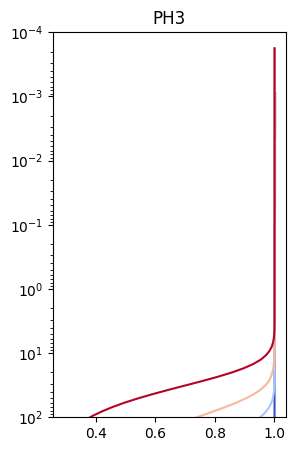

In [97]:
fig, ax = plt.subplots(figsize=(3,5))
for i, T_eff_i in enumerate(T_eff):
    zorder = np.argwhere(np.sort(T_eff)==T_eff_i)[0][0]-10
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    kwargs = dict(
        c=c, lw=1.5, zorder=zorder, clip_on=True,
    )
    ax.plot(VMR['H3P1'][i]/VMR_tot['P'][i], P[i], **kwargs)

ax.set(yscale='log', ylim=(1e2,1e-4), title='PH3')
plt.show()

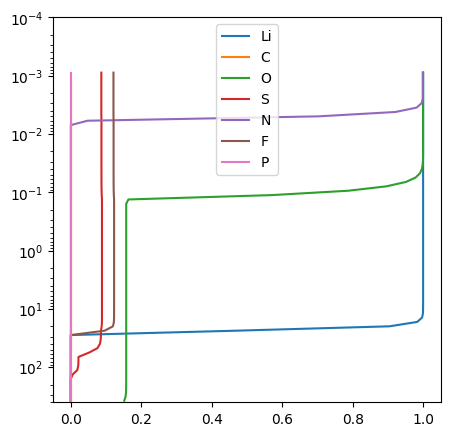

In [98]:
j = 0
fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(cond['LiF(s)'][j], P[j], c='darkorchid', lw=1.5, label='LiF(s)')
for species_i, cond_degree_i in cond_degree.items():
    ax.plot(cond_degree_i[j], P[j], lw=1.5, label=species_i)
ax.legend()
ax.set(yscale='log', ylim=(4e2,1e-4))
plt.show()

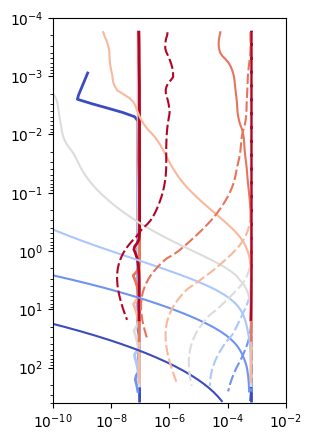

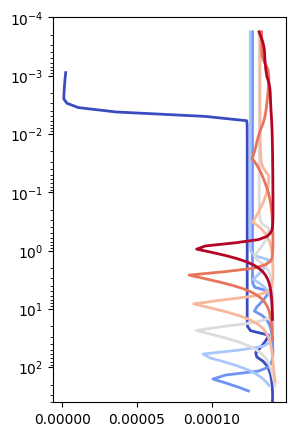

In [17]:
fig, ax = plt.subplots(figsize=(3,5))
for j, T_eff_i in enumerate(T_eff):
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))

    ax.plot(VMR['C1O1'][j], P[j], c=c, lw=1.5, label='CO')
    ax.plot(VMR['C1H4'][j], P[j], c=c, ls=(0,(5,1.65)), lw=1.5, label='CH4')
    ax.plot(VMR['C1O1'][j]+VMR['C1H4'][j], P[j], c=c, zorder=-1, lw=2, label='CO+CH4')

    ax.plot(VMR['F1H1'][j], P[j], c=c, zorder=-1, lw=2, label='HF')

ax.set(yscale='log', xscale='log', ylim=(4e2,1e-4), xlim=(1e-10,1e-2))
plt.show()

fig, ax = plt.subplots(figsize=(3,5))
for j, T_eff_i in enumerate(T_eff):
    c = cmap((T_eff_i-T_eff.min())/(T_eff.max()-T_eff.min()))
    
    ax.plot(VMR['F1H1'][j]/(VMR['C1O1'][j]+VMR['C1H4'][j]), P[j], c=c, zorder=-1, lw=2, label='F/C')

# ax.set(yscale='log', xscale='log', ylim=(4e2,1e-4), xlim=(1e-10,1e-2))
ax.set(yscale='log', ylim=(4e2,1e-4))
plt.show()

8.19246675417686e-06
2.7893906513837413e-05
7.820701036860347e-06
4.016417203026343e-06
5.416322824117292e-06
9.30726213042159e-06
6.41859759996673e-06
3.248633293652498e-05
2.5804811494135143e-05
2.6191318943130428e-05
4.1092321962386025e-05
9.882540921318857e-06


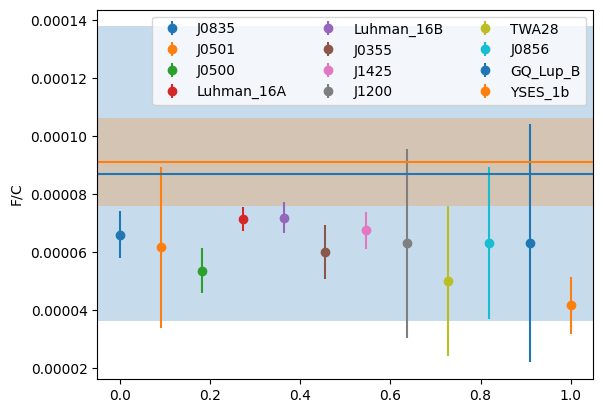

In [42]:
C = {
    'J0835':(-2.85,0.02), 'J0501':(-2.89,0.05), 'J0500':(-3.03,0.02), 
    'Luhman_16A':(-3.124,0.014), 'Luhman_16B':(-3.307,0.013), 
    'J0355':(-2.74,0.03), 'J1425':(-2.92,0.01),
    'J1200':(-4.0,0.1), 'TWA28':(-3.7,0.1), 'J0856':(-3.7,0.1), 
    'GQ_Lup_B':(-3.4,0.2),
    'YSES_1b':(-2.14,0.05), 
}
F = {
    'J0835':(-7.03,0.05), 'J0501':(-7.10,0.19), 'J0500':(-7.30,0.06), 
    'Luhman_16A':(-7.27,0.02), 'Luhman_16B':(-7.45,0.03),
    'J0355':(-6.96,0.06), 'J1425':(-7.09,0.04),
    'J1200':(-8.2,0.2), 'TWA28':(-8.0,0.2), 'J0856':(-7.9,0.15), 
    'GQ_Lup_B':(-7.6,0.2), 
    'YSES_1b':(-6.52,0.09),
}

x = np.linspace(0,1,len(C))
for i, x_i in enumerate(x):
    key_i = list(C.keys())[i]
    VMR_CO, e_VMR_CO = C[key_i]
    VMR_HF, e_VMR_HF = F[key_i]

    # ratio = 10**VMR_CO/10**VMR_HF
    ratio = 10**VMR_HF/10**VMR_CO
    e_ratio = np.sqrt(
        (np.log(10)*ratio)**2 * (e_VMR_CO**2 + e_VMR_HF**2)
    )
    print(e_ratio)
    plt.errorbar(x_i, ratio, yerr=e_ratio, fmt='o', label=key_i)

ratio = 10**(4.40)/10**(8.46)
e_ratio = np.sqrt((np.log(10)*ratio)**2 * (0.25**2 + 0.04**2))
plt.axhline(ratio)
plt.axhspan(ratio-e_ratio, ratio+e_ratio, color='C0', alpha=0.25, lw=0)

ratio = 10**(4.42)/10**(8.46)
e_ratio = np.sqrt((np.log(10)*ratio)**2 * (0.06**2 + 0.04**2))
plt.axhline(ratio, color='C1')
plt.axhspan(ratio-e_ratio, ratio+e_ratio, color='C1', alpha=0.25, lw=0)

plt.legend(ncols=3)
plt.ylabel(r'$\mathrm{F/C}$')
plt.show()

In [18]:
index_F = FC.fastchem.getElementIndex('F')
index_C = FC.fastchem.getElementIndex('C')
FC.fastchem.getElementAbundance(index_F) / FC.fastchem.getElementAbundance(index_C)

0.00014125375446227554

1300 K


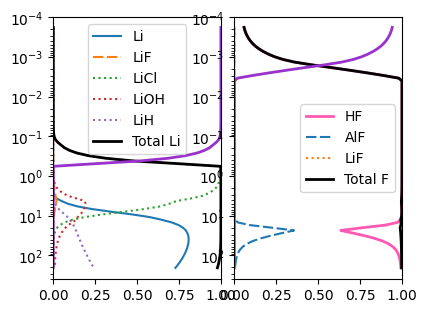

In [124]:
j = 3
print(T_eff[j], 'K')

fig = plt.figure(figsize=(4.5,3.4))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.08, width_ratios=[0.2,0.2])
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[0,1]), 
])

ax[0].plot(VMR['Li'][j]/VMR_tot['Li'][j], P[j], lw=1.5, label='Li')
ax[0].plot(VMR['F1Li1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(5,1.65)), lw=1.5, label='LiF')
ax[0].plot(VMR['Cl1Li1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='LiCl')
ax[0].plot(VMR['H1Li1O1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='LiOH')
ax[0].plot(VMR['H1Li1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='LiH') 
ax[0].plot(
    (VMR['Li'][j]+VMR['F1Li1'][j]+VMR['Cl1Li1'][j]+VMR['H1Li1O1'][j]+VMR['H1Li1'][j]) / VMR_tot['Li'][j],
    P[j], c='k', lw=2, label='Total Li'
    )


# ax_cond = ax[0].twiny()
#ax_cond.plot(cond['LiF(s,l)'][j], P[j], c='darkorchid', lw=1.5, label='LiF(s,l)')
#ax_cond.set(yscale='log', xscale='log', ylim=(4e2,1e-4))
index = FC.fastchem.getElementIndex('Li')
total_element_density  = np.array(FC.output.total_element_density)[::-1]
total_element_density *= np.array(FC.fastchem.getElementAbundance(index)) / np.sum(FC.fastchem.getElementAbundances())
# ax_cond.plot(cond['LiF(s,l)'][j]/total_element_density[j], P[j], c='darkorchid', lw=1.5, label='LiF(s,l)')
ax[0].plot(cond_degree['Li'][j], P[j], c='darkorchid', lw=2)
# ax_cond.set(yscale='log', ylim=(4e2,1e-4), xlim=(0,1))

ax[0].legend()
ax[0].set(yscale='log', xlim=(0,1), ylim=(4e2,1e-4))

ax[1].plot(VMR['F1H1'][j]/VMR_tot['F'][j], P[j], lw=2, c=color_species['HF'], label='HF')
ax[1].plot(VMR['Al1F1'][j]/VMR_tot['F'][j], P[j], lw=1.5, ls=(0,(5,1.65)), label='AlF')

ax[1].plot(VMR['F1Li1'][j]/VMR_tot['F'][j], P[j], lw=1.5, ls=(0,(1,1.65)), label='LiF')
# ax[1].plot(FC.get_VMR('F1K1')/VMR_tot['F'][j], P[j], lw=1.5, ls=(0,(5,1.65)), label='KF')
# ax[1].plot(FC.get_VMR('F1Na1')/VMR_tot['F'][j], P[j], lw=1.5, ls=(0,(1,1.65)), label='NaF')

ax[1].plot(
    (VMR['F1H1'][j]+VMR['Al1F1'][j]+VMR['F1Li1'][j]) / VMR_tot['F'][j], P[j], c='k', lw=2, label='Total F'
)

ax[1].legend()
ax[1].set(yscale='log', xlim=(0,1), ylim=(4e2,1e-4))

ax[1].plot(cond_degree['F'][j], P[j], c='darkorchid', lw=2)

'''
n_lines = 0
for i in range(FC.fastchem.getGasSpeciesNumber()):
    symbol = FC.fastchem.getGasSpeciesSymbol(i)
    if 'F' not in symbol:
        continue

    suffix = symbol.split('F')[-1]
    if suffix.startswith('e'):
        continue

    n_lines += 1
    if n_lines <= 100:
        continue
    ax[1].plot(FC.get_VMR(symbol)/VMR_tot['F'][j], P[j], lw=1, label=symbol)
    print(symbol)
    if n_lines > 200:
        break
'''
# ax_cond.legend(ncols=4, loc='lower left')

# ax[1].plot(5*FC.get_VMR('F1K1')/VMR_tot['F'][j], P[j], lw=2, c='k')
# ax[1].plot(5*FC.get_VMR('F1Li1')/VMR_tot['F'][j], P[j], lw=2, c='k')
# ax[1].plot(5*FC.get_VMR('F1Na1')/VMR_tot['F'][j], P[j], lw=2, c='k')

plt.show()

1300 K
[-0.02977895 -0.02977895 -0.02977895 -0.02977895 -0.02977895 -0.02977895
 -0.02977895 -0.02977895 -0.02977895 -0.02977895 -0.02977895 -0.02977895
 -0.02977895 -0.02977895 -0.02977894 -0.02977894 -0.02977894 -0.02977894
 -0.02977893 -0.02977893 -0.02977892 -0.02977891 -0.02977891 -0.02977889
 -0.02977888 -0.02977886 -0.02977883 -0.0297788  -0.02977874 -0.02977863
 -0.02977845 -0.0297782  -0.02977786 -0.02977741 -0.02977678 -0.02977584
 -0.02977438 -0.0297721  -0.02976844 -0.02976246 -0.02975244 -0.02973531
 -0.02970542 -0.02965302 -0.02956058 -0.02939635 -0.02910318 -0.02856265
 -0.02740219 -0.02216867 -0.00890667 -0.01003198 -0.01227472 -0.01591837
 -0.02095861 -0.02690258 -0.03338492 -0.04105152 -0.03458228 -0.02228151
 -0.01442331 -0.00942277 -0.00622685 -0.00444853 -0.0028692  -0.00191204
 -0.00131138 -0.00093269 -0.00072081 -0.00071782 -0.00114141 -0.00248428
 -0.00458404 -0.0116684  -0.04092526 -0.11835487 -0.19725419 -0.15005598
 -0.10878807 -0.07626484 -0.05258673 -0.0361

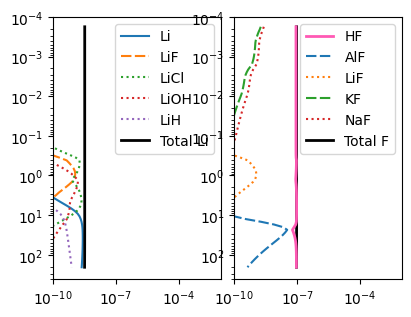

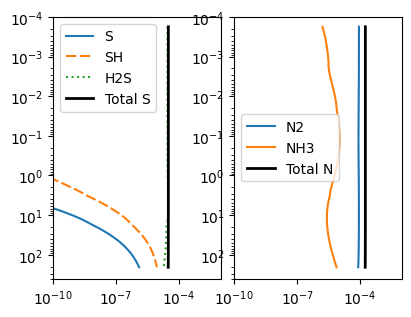

In [6]:
j = 3
print(T_eff[j], 'K')

fig = plt.figure(figsize=(4.5,3.4))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.08, width_ratios=[0.2,0.2])
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[0,1]), 
])

ax[0].plot(VMR['Li'][j], P[j], lw=1.5, label='Li')
ax[0].plot(VMR['F1Li1'][j], P[j], ls=(0,(5,1.65)), lw=1.5, label='LiF')
ax[0].plot(VMR['Cl1Li1'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='LiCl')
ax[0].plot(VMR['H1Li1O1'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='LiOH')
ax[0].plot(VMR['H1Li1'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='LiH') 
ax[0].plot(VMR_tot['Li'][j], P[j], c='k', lw=2, label='Total Li')
# ax[0].axvline(10**(3.39-12), color='r')

ax[0].legend()
ax[0].set(yscale='log', xscale='log', ylim=(4e2,1e-4), xlim=(1e-10,1e-2))

ax[1].plot(VMR['F1H1'][j], P[j], lw=2, c=color_species['HF'], label='HF')
ax[1].plot(VMR['Al1F1'][j], P[j], lw=1.5, ls=(0,(5,1.65)), label='AlF')
ax[1].plot(VMR['F1Li1'][j], P[j], lw=1.5, ls=(0,(1,1.65)), label='LiF')
ax[1].plot(FC.get_VMR('F1K1'), P[j], lw=1.5, ls=(0,(5,1.65)), label='KF')
ax[1].plot(FC.get_VMR('F1Na1'), P[j], lw=1.5, ls=(0,(1,1.65)), label='NaF')
ax[1].plot(VMR_tot['F'][j], P[j], lw=2, zorder=-1, c='k', label='Total F')
# ax[1].axvline(10**(4.75-12), color='r')

print(np.log10(VMR['F1H1'][j])-np.log10(VMR_tot['F'][j]), P[j][0], P[j][-1])
print((VMR['F1H1'][j]-VMR_tot['F'][j])/VMR_tot['F'][j], P[j][0], P[j][-1])

ax[1].legend()
ax[1].set(yscale='log', xscale='log', ylim=(4e2,1e-4), xlim=(1e-10,1e-2))

plt.show()

fig = plt.figure(figsize=(4.5,3.4))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.08, width_ratios=[0.2,0.2])
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[0,1]), 
])

ax[0].plot(VMR['S'][j], P[j], lw=1.5, label='S')
ax[0].plot(VMR['H1S1'][j], P[j], ls=(0,(5,1.65)), lw=1.5, label='SH')
ax[0].plot(VMR['H2S1'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='H2S')
ax[0].plot(VMR_tot['S'][j], P[j], c='k', lw=2, label='Total S')

ax[0].legend()
ax[0].set(yscale='log', xscale='log', ylim=(4e2,1e-4), xlim=(1e-10,1e-2))

ax[1].plot(VMR['N2'][j], P[j], lw=1.5, label='N2')
ax[1].plot(VMR['H3N1'][j], P[j], lw=1.5, label='NH3')
ax[1].plot(VMR_tot['N'][j], P[j], lw=2, zorder=-1, c='k', label='Total N')

ax[1].legend()
ax[1].set(yscale='log', xscale='log', ylim=(4e2,1e-4), xlim=(1e-10,1e-2))

plt.show()

In [ ]:
j = 30
print(FC.fastchem.getElementSymbol(j))
# index = FC.fastchem.getElementIndex('F')
# print(index)
(np.array(FC.output.element_conserved)[::-1,j]==1).all()

In [ ]:
# FC.fastchem.getGasSpeciesSymbol()
# for 
# FC.fastchem.getGasSpeciesSymbol(100)

In [ ]:
FC.fastchem.getCondSpeciesSymbol(2)

In [ ]:
j = 0
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(FC.get_VMR('F1H1')/VMR_tot['F'][j], P[j], c='k', lw=3)
ax_cond = ax.twiny()
# ax.plot(FC.get_VMR('F6H6')/VMR_tot['F'][j], P[j], c='k', lw=1.5)

n_lines = 0
for i in range(FC.fastchem.getCondSpeciesNumber()):
    symbol = FC.fastchem.getCondSpeciesSymbol(i)
    if 'F' not in symbol:
        continue

    suffix = symbol.split('F')[-1]
    if suffix.startswith('e'):
        continue

    n_lines += 1
    if n_lines <= 0:
        continue
    ax_cond.plot(FC.get_condensate_number_density(symbol), P[j], lw=1, label=symbol)
    if n_lines > 150:
        break
ax_cond.legend(ncols=4, loc='lower left')
ax.set(
    yscale='log', xlabel='Number density (cm$^{-3}$)', ylabel='Pressure (bar)', ylim=(1e2,1e-4), xlim=(0,1)
)
ax_cond.set(xscale='log')
plt.show()

In [ ]:
j = 0
print(T_eff[j])
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(VMR['Li'][j]/VMR_tot['Li'][j], P[j], lw=1.5, label='Li')
ax.plot(VMR['F1Li1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(5,1.65)), lw=1.5, label='F1Li1')
ax.plot(VMR['Cl1Li1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='Cl1Li1')
ax.plot(VMR['H1Li1O1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='H1Li1O1')
ax.plot(VMR['H1Li1'][j]/VMR_tot['Li'][j], P[j], ls=(0,(1,1.65)), lw=1.5, label='H1Li1') 
ax.plot(
    (VMR['Li'][j]+VMR['F1Li1'][j]+VMR['Cl1Li1'][j]+VMR['H1Li1O1'][j]+VMR['H1Li1'][j]) / VMR_tot['Li'][j],
    P[j], c='k', lw=2, label='Total Li'
    )
ax.legend()
ax.set(yscale='log', xlim=(0,1), ylim=(1e3,1e-4))
plt.show()

## Attempts to derive the condensation curve

In [ ]:
from scipy.optimize import root_scalar

def f(T, y, a0, a1, b0, b1, b2):
    return y - (a0/T + a1*np.log(T) + b0 + b1*T + b2*T**2)

def fprime(T, y, a0, a1, b0, b1, b2):
    return -a0/T**2 - a1/T + b1 + 2*b2*T

pressure = np.logspace(-4,3,50)

ln_K = -1 * (
    7*np.log(pressure) + 2*np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('Mg'))) +
    np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('Si'))) +
    4*np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('O')))
)
popt = [4.6852445155461133e+05, -1.2607653994717314e+01, -4.5339086543552966e+01, 1.4741562650506954e-02, -2.0198470902129289e-06]
# popt = [4.6720078474079439e+05, 3.1053441505271406e+00, -1.4543102275555322e+02, 1.3483324908687023e-03, -8.1109421159829791e-08]

ln_K = -1 * (
    2*np.log(pressure) + np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('Li'))) +
    np.log(1.0*FC.fastchem.getElementAbundance(FC.fastchem.getElementIndex('F')))
)
popt = [1.0565687551148905e+05, 2.3860922168323690e+01, -1.6755337045765026e+02, -2.2387464479935778e-02, -2.9200476042869772e-06]

T_cond = np.nan * np.ones_like(ln_K)
for i, ln_K_i in enumerate(ln_K):
    sol = root_scalar(f, args=(ln_K_i, *popt), bracket=[500, 5000], fprime=fprime)
    if sol.converged:
        T_cond[i] = sol.root

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(T_cond, pressure, label='Condensation temperature')
# ax.plot(1e4/(5.89-0.37*np.log10(pressure)), pressure, label='Condensation temperature (from FC)')
ax.set(yscale='log', xlabel='Temperature [K]', ylabel='Pressure [bar]', ylim=(1e3,1e-4), xlim=(0,3500))
ax.legend()
plt.show()

## Other diagnostics

In [ ]:
j = 4

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(cond['LiF(s)'][j], P[j], label='LiF(s)', lw=1, c='C0')
ax.plot(cond['Al2O3(s,l)'][j], P[j], label='Al2O3(s,l)', lw=1, c='C1')
ax.set(yscale='log', xlabel='Number density [cm$^{-3}$]', ylabel='Pressure [bar]', ylim=(1e3,1e-4), xscale='log')
plt.show()

In [ ]:
j = 4

fig, ax = plt.subplots()
ax.plot(cond_degree['Li'][j], P[j], c='k', lw=1.5, label='Li')
ax.plot(cond_degree['C'][j], P[j], c='C2', lw=1.5, label='C')
ax.plot(cond_degree['O'][j], P[j], c='C3', lw=1.5, label='O')
ax.plot(cond_degree['S'][j], P[j], c='C1', lw=1.5, label='S')
ax.plot(cond_degree['N'][j], P[j], c='C8', lw=1.5, label='N')
ax.plot(cond_degree['F'][j], P[j], c='C4', lw=1.5, label='F')
ax.legend()
ax.set(
    xlabel='Condensation degree', ylabel='Pressure (bar)', 
    xlim=(0,1), ylim=(4e2,1e-4), yscale='log'
)
plt.show()

In [ ]:
cond['LiF(s)']

In [ ]:
j = 5

fig, ax = plt.subplots()
ax.plot(cond['LiF(s,l)'][j], P[j], label='LiF(s,l)', c='k')
ax.legend(loc='upper right', fontsize=11, frameon=False)
ax.set(yscale='log', ylim=(4e2,1e-4), xlabel='VMR', ylabel='Pressure (bar)', xscale='log')
plt.show()

In [ ]:
j = 0

fig, ax = plt.subplots()
ax.plot(VMR['Li'][j], P[j], label='Li', c='k')
ax.plot(VMR['F1Li1'][j], P[j], label='liF', c='C0')
ax.plot(VMR['H1Li1'][j], P[j], label='LiH', c='C1')
ax.plot(VMR['Cl1Li1'][j], P[j], label='LiCl', c='C2')
ax.plot(VMR['H1Li1O1'][j], P[j], label='LiOH', c='C3')
ax.plot(VMR['H2Li2O2'][j], P[j], label='Li2O2H2', c='C4')
ax.legend(loc='upper right', fontsize=11, frameon=False)
ax.set(yscale='log', ylim=(4e2,1e-4), xlabel='VMR', ylabel='Pressure (bar)', xscale='log')
plt.show()